In [4]:
#!conda activate jupyterlab-copilot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#!pip install netCDF4
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import multiprocessing as mp
import geopandas
#!pip install descartes
import descartes
from datetime import date

from datetime import datetime

In [5]:
import pickle
# drive_path = '/Users/kaichiht/Library/CloudStorage/GoogleDrive-kuiper2000@gmail.com/My Drive/'
# # Load the pkl file
# with open(drive_path+'website-hugo/chaos_and_predictability/week9/Predictable_component_analysis/PNA_region.pkl', 'rb') as file:
#     data = pickle.load(file)
with open('PNA_region.pkl', 'rb') as file:
    data = pickle.load(file)

print(data['PC dimension'])
print(data['EOF dimension'])

PC  = data['PC']
EOF = data['EOF']
lat = data['lat']
lon = data['lon']

10 ensembles, 20 years, 12 months, 8 initialization (for each month), 47 lead time, 10 modes
10 modes, 20<lat<80, 100<lon<300


In [12]:
initialization

4

In [59]:
## calculate the det without coordinate transform 
month            = [0,1,10,11]
PC_winter        = PC[:,:,month,:,:]
L                = np.zeros((20,4,8,47,10,10))
L_normalize      = np.zeros((20,4,8,47,10,10))
v                = np.zeros((20,4,8,47,10))
for year in range(20):
    for month in range(4):
        for initialization in range(8):
            for lead in range(46):
                tmp_0  = PC_winter[:,year,month,initialization,lead,:]
                tmp_1  = PC_winter[:,year,month,initialization,lead+1,:]
                lambda_reg = 1e-2  # Small value to stabilize inversion
                identity_matrix = np.eye(tmp_0.shape[1])  # Identity matrix (10x10)
                L[year,month,initialization,lead,:,:]   = np.linalg.inv(tmp_0.T.dot(tmp_0)+lambda_reg * identity_matrix).dot(tmp_0.T.dot(tmp_1))
                v[year,month,initialization,lead,:],m   = np.linalg.eig(L[year,month,initialization,lead,:,:].T.dot(L[year,month,initialization,lead,:,:]))
                #L_normalize[year,month,initialization,lead,:,:] = L[year,month,initialization,lead,:,:]/np.sum(v)
                #v   = v/np.sum(v)
v_avg = v[:,:,:,:46,:].sum(axis=(0,1,2,4))
for lead in range(46):
    L_normalize[:,:,:,lead,:,:]    = L[:,:,:,lead,:,:]/v_avg[lead]

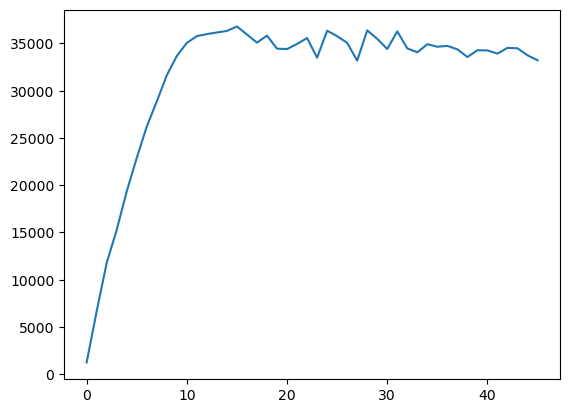

In [53]:
plt.figure()
plt.plot(v[:,:,:,:46,:].sum(axis=(0,1,2,4)))



Mean Squared Error: 8.738832908898094e-09
R² Score: 0.18801659739094817


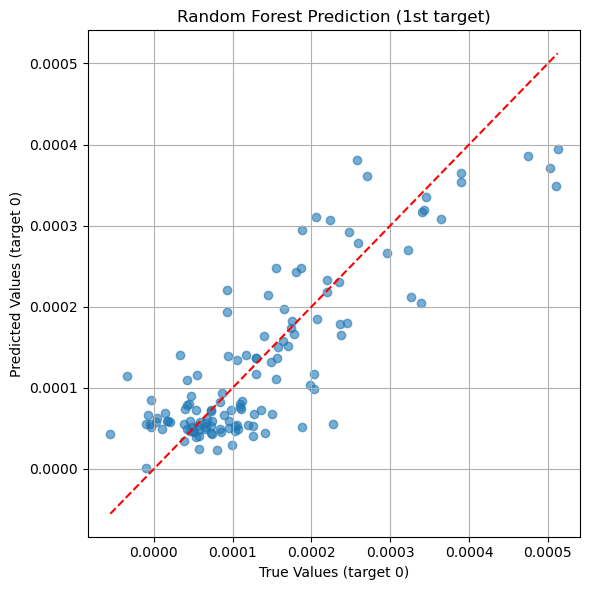

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata, norm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

coefs = L_normalize[:,:,:,0,:,:]
# Generate x and y from input data
x = PC_winter[:,:,:,:,0,:].mean(axis=(0,)).reshape([640,10])  # Shape (640,10)
y = coefs.reshape([640,10*10])  # Shape (640,2) → 10 target variables



# Split the data into training (70%) and testing (30%)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Optionally scale the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

# Initialize the Random Forest model
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
# base_model = RandomForestRegressor(
#     n_estimators=100,  # Lower number = less capacity
#     max_depth=10,
#     min_samples_leaf=3,
#     max_features='sqrt',
#     random_state=40
# )
model = MultiOutputRegressor(base_model)

# Fit the model
model.fit(x_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(x_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

# Optional: visualize predictions for one of the output targets
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.6)
plt.xlabel("True Values (target 0)")
plt.ylabel("Predicted Values (target 0)")
plt.title("Random Forest Prediction (1st target)")
plt.grid(True)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')  # 1:1 line
# plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
#          [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')  # 1:1 line
plt.tight_layout()
plt.show()


Mean Squared Error: 8.738832908898095e-09
R² Score: 0.7164377358005081


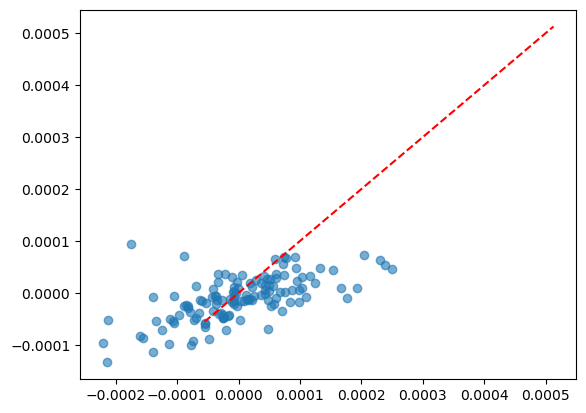

In [168]:
# Evaluate performance
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
r2 = r2_score(y_test[:, 0].flatten(), y_pred[:, 0].flatten())

print("Mean Squared Error:", mse)
print("R² Score:", r2)


plt.scatter(y_test[:, 3].flatten(), y_pred[:, 1].flatten(), alpha=0.6)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')  # 1:1 line

Mean Squared Error: 8.624031743354508e-09
R² Score: 0.2899194802814826


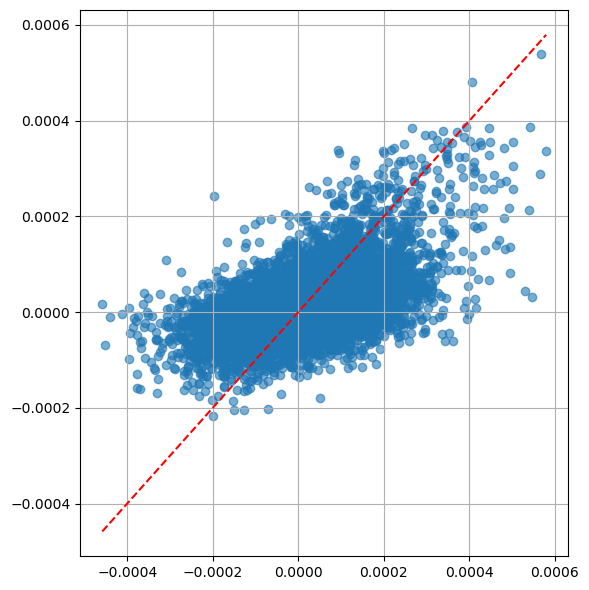

In [146]:
#L_convert = np.linalg.inv(y_pred.T.dot(y_pred)).dot(y_pred.T.dot(y_test))
y_pred_2  = y_pred.dot(L_convert)
mse       = mean_squared_error(y_test.flatten(), y_pred.flatten())
r2        = r2_score(y_test.flatten(), y_pred.flatten())
print("Mean Squared Error:", mse)
print("R² Score:", r2)
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:, :].flatten(), y_pred[:, :].flatten(), alpha=0.6)
plt.plot([y_test[:, :].min(), y_test[:, :].max()], 
         [y_test[:, :].min(), y_test[:, :].max()], 'r--')  # 1:1 line
plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
tmp_1 = np.reshape(y_test,[128,10,10])
tmp_2 = np.reshape(y_pred_2,[128,10,10])
tmp_1_cov = tmp_1[0,:,:].T.dot(tmp_1[0,:,:])
tmp_2_cov = tmp_2[0,:,:].T.dot(tmp_2[0,:,:])
v1,m1     = np.linalg.eig(tmp_1_cov)
v2,m2     = np.linalg.eig(tmp_2_cov)

[ 0.04584457  0.70444905 -0.01661522  0.03098675 -0.39645821  0.25276319
 -0.1830105   0.43588448 -0.13667568  0.192813  ]
[ 0.0545131   0.67923146  0.01709922  0.12821734 -0.39484998  0.2953737
 -0.2326208   0.3379867  -0.12446186  0.3032335 ]
[8.78913646e-07 1.77266406e-07 9.11561433e-08 4.06093573e-08
 2.35874543e-08 1.75626021e-08 1.18664197e-08 4.47523790e-09
 1.03442134e-10 6.26904838e-10]


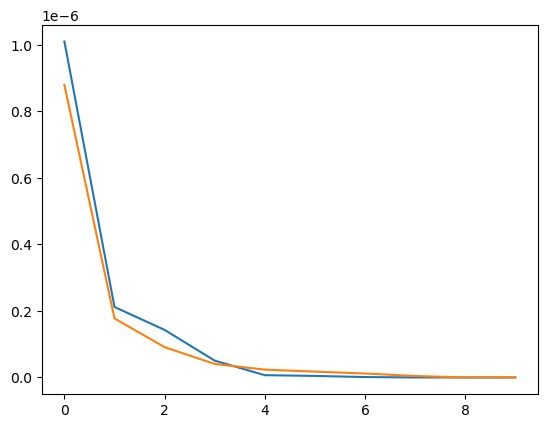

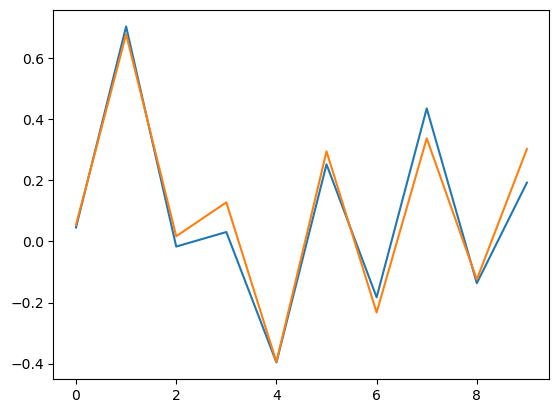

In [138]:
print(m1[:,0])
print(-m2[:,0])

plt.figure()
plt.plot(v1,label='truth')
plt.plot(v2,label='pred')

plt.figure()
plt.plot(m1[:,0],label='truth')
plt.plot(-m2[:,0],label='pred')
print(v2)